

APTOS 2019 Kaggle competition.

A Notebook  for Training a  neural network.

Using PyTorch framework. 

Using Transfer Learning .

The Data for Training is from the old competition in Kaggle, and Validation is  the APTOS 2019 Data 
 
 Using  EfficientNet B4 
 https://arxiv.org/pdf/1905.11946.pdf


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


## Install Nvidia driver 
Using Invidia Apex Driver 

For Mixed precision training (FP16 & FP32)

In [0]:
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidia-apex-15aug2019/apex-master/apex-master/

## Import Libraries  

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random
from PIL import Image
from tqdm import tqdm_notebook
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import argparse
import numpy as np
import pandas as pd
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import tqdm 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from tqdm._tqdm_notebook import tqdm_notebook


from apex import amp
import cv2

# Albumentations
albumentations is a fast image augmentation library and easy to use wrapper around other libraries.

In [0]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma ,
    RandomScale
)

## Load Ext Data 

In [0]:
ext_train = pd.read_csv("../input/aptos-ext-data/groundtruths/a. IDRiD_Disease Grading_Training Labels.csv")
ext_valid = pd.read_csv("../input/aptos-ext-data/groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv")

In [0]:
 
ext_train = ext_train.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"})
ext_valid = ext_valid.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"})

In [0]:
ext_train = ext_train[['id_code','diagnosis']]
ext_valid = ext_valid[['id_code','diagnosis']]

In [0]:
PATH_EXT_TRAIN_IMAGE = "../input/aptos-ext-data/images/a. Training Set/"
ext_train['id_code'] = ext_train['id_code'].apply(lambda x : PATH_EXT_TRAIN_IMAGE+str(x)+".jpg" )
ext_train.head()

,id_code,diagnosis
0,../input/aptos-ext-data/images/a. Training Set...,3
1,../input/aptos-ext-data/images/a. Training Set...,3
2,../input/aptos-ext-data/images/a. Training Set...,2
3,../input/aptos-ext-data/images/a. Training Set...,3
4,../input/aptos-ext-data/images/a. Training Set...,4


In [0]:
PATH_EXT_VALID_IMAGE = "../input/aptos-ext-data/images/b. Testing Set/"
ext_valid['id_code'] = ext_valid['id_code'].apply(lambda x : PATH_EXT_VALID_IMAGE+str(x)+".jpg" )
ext_valid.head()

,id_code,diagnosis
0,../input/aptos-ext-data/images/b. Testing Set/...,4
1,../input/aptos-ext-data/images/b. Testing Set/...,4
2,../input/aptos-ext-data/images/b. Testing Set/...,4
3,../input/aptos-ext-data/images/b. Testing Set/...,4
4,../input/aptos-ext-data/images/b. Testing Set/...,4


## Global Variables 
global variables definitions 

In [0]:
IMAGE_SIZE = 256 
SEED = 1843
PATH = "../input/train_images"
EPOCH = 30
NUM_MODEL = 1
batch_size = 16
RandCrop_Prob = 0.7
Min_CROP_FACTOR = 0.75
Max_CROP_FACTOR = 0.95

## Random Seed 

In [0]:
def seed_all(seed= SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_all(seed= SEED)

## Random Zoom 

In [0]:
def  Randomzoom(image,prob=1):
    aug = RandomScale(scale_limit=0.3, p=prob)
    augmented = aug(image=image)

    image = augmented['image']

    return image

## Center Randon Crop 

In [0]:
Prob = RandCrop_Prob 
Min = Min_CROP_FACTOR 
Max = Max_CROP_FACTOR 

def  RandCenterCrop(image):
       
    
    
    original_height , original_width = image.shape[:2]
   
    
    RandCropFactor = random.uniform(Min,Max)
    if RandCropFactor > 1 : 
        print(RandCropFactor)
        RandCropFactor = 1
    width = int(RandCropFactor * original_width)
    height = int(RandCropFactor * original_height)
    image = np.asarray(image)    
       
    aug = CenterCrop(p=Prob, height=height, width=width)
    augmented = aug(image=image)

    image_center_cropped = augmented['image']

    return image_center_cropped
    

## Horizontal Flip

In [0]:
def RandHorizontalFlip(image , Prob = 1):
    aug = HorizontalFlip(p=Prob)

    augmented = aug(image = image)

    image = augmented['image']
   

    return image

## Vertical Flip

In [0]:
def RandHVerticalFlip(image , Prob = 1):
    aug = VerticalFlip(p=Prob)

    augmented = aug(image = image)

    image = augmented['image']
   

    return image

## Random Rotate

In [0]:
def RandRotate(image , Prob = 1):
    aug = RandomRotate90(p=Prob)

    augmented = aug(image = image)

    image = augmented['image']
   

    return image

## Horizontal Flip

In [0]:
def RandBrightContrast (image , Prob = 1):
    aug = RandomBrightnessContrast(p=Prob)

    augmented = aug(image = image)

    image = augmented['image']
   

    return image




## Read Meta Data 

In [0]:
train = pd.read_csv("../input/aptos-5-folds/train2.csv") 
train.head()

,id_code,diagnosis
0,a3bd2e034614,0
1,a11c62cb3f86,0
2,7f84284598f5,2
3,17eb5d4ad740,2
4,8fbb2ca39911,0


In [0]:
PATH_TRAIN_IMAGE = "../input/aptos2019-blindness-detection/train_images/"
train['id_code'] = train['id_code'].apply(lambda x : PATH_TRAIN_IMAGE+str(x)+".png" )
train.head()

,id_code,diagnosis
0,../input/aptos2019-blindness-detection/train_i...,0
1,../input/aptos2019-blindness-detection/train_i...,0
2,../input/aptos2019-blindness-detection/train_i...,2
3,../input/aptos2019-blindness-detection/train_i...,2
4,../input/aptos2019-blindness-detection/train_i...,0


In [0]:
val = pd.read_csv("../input/aptos-5-folds/valid2.csv") 
val.head()

,id_code,diagnosis
0,34723fae6475,2
1,1a1b4b2450ca,2
2,cc12453ea915,1
3,77e15f213b04,0
4,99ecdb41d5e7,1


In [0]:
PATH_TRAIN_IMAGE = "../input/aptos2019-blindness-detection/train_images/"
val['id_code'] = val['id_code'].apply(lambda x : PATH_TRAIN_IMAGE+str(x)+".png" )
val.head()

,id_code,diagnosis
0,../input/aptos2019-blindness-detection/train_i...,2
1,../input/aptos2019-blindness-detection/train_i...,2
2,../input/aptos2019-blindness-detection/train_i...,1
3,../input/aptos2019-blindness-detection/train_i...,0
4,../input/aptos2019-blindness-detection/train_i...,1


In [0]:
df = pd.concat([val, ext_valid], axis=0)
val = df
val.shape

(470, 2)

In [0]:
df = pd.concat([train, ext_train], axis=0)
train = df
train.shape

(3708, 2)

## Image Pre Process 

In [0]:
#The Code from: https://www.kaggle.com/ratthachat/aptos-updated-albumentation-meets-grad-cam

def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [0]:
def get_image(path, id_code, size,Aug):
    img_path = path
    
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if Aug:
        image = Randomzoom(image , prob = 0.7)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (size, size))
    if Aug:
        #image = RandCenterCrop(image)
        #image = RandomBrightContrast(image)
        image = RandHorizontalFlip(image,Prob=0.8)
        image = RandHVerticalFlip(image,Prob=0.8)
        image = RandRotate(image,Prob=0.6)
        image = RandBrightContrast(image,Prob=0.6)
       
    
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
    image = transforms.ToPILImage()(image)
    return image

## Image Data Loader class 

In [0]:
class ImageDataLoader(torch.utils.data.Dataset):

    def __init__(self,train_file,root_dir,size =256,transform=None,Aug = False):
        """
        Args:
            train_file(string): path to train file (meta data )
            root_dir(string): directory with all train images
        """
        self.root_dir = root_dir
        self.size = size
        self.name_frame = train_file['id_code'].values
        self.label_frame = train_file['diagnosis'].values
        self.transform = transform
        self.Aug = Aug
        

    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        
       
       
        #img_name = os.path.join(self.root_dir, self.name_frame[idx]+str(".png"))
        img_name = self.name_frame[idx]
        image = get_image(img_name, idx, self.size,self.Aug)
                
        label = self.label_frame[idx]
        
          
              
        
        if self.transform:
            image = self.transform(image);
            
        
      
        
        #return {'image': image,
        #        'labels': label
        #        }
        
        return {'image': image,
                'labels': label
                }
        
        
        
        

## Visualize Class  

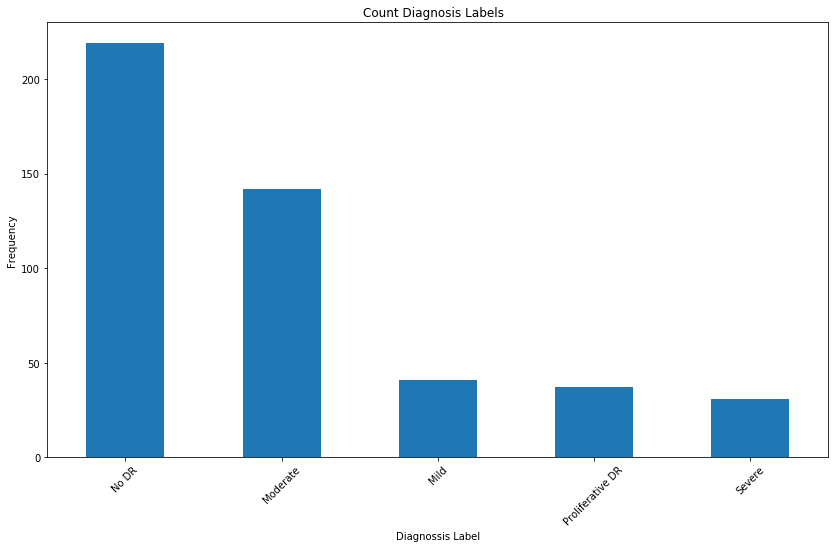

In [0]:
ax = val['diagnosis'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Count Diagnosis Labels  ")
ax.set_xlabel("Diagnossis Label")
ax.set_ylabel("Frequency")
ax.set_xticklabels( labels = list(('No DR', 'Moderate', 'Mild', 'Proliferative DR', 'Severe')),rotation=45)
plt.show()

## Data Loader 
Create Train and Validation loader 

In [0]:
transform_ori = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation((-120, 120)),
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    


TrainSet = ImageDataLoader(train_file = train,root_dir = "../input/aptos2019-blindness-detection/train_images/",size=IMAGE_SIZE,transform = transform_ori,Aug=True)
                                  

                                       
ValidSet = ImageDataLoader(train_file = val,root_dir = "../input/aptos2019-blindness-detection/train_images/",size=IMAGE_SIZE,transform = transform_ori,Aug=False)
                                


TrainLoader = torch.utils.data.DataLoader(TrainSet,batch_size=batch_size,shuffle=True, num_workers=4)
ValidLoader = torch.utils.data.DataLoader(ValidSet,batch_size=batch_size,shuffle=False, num_workers=4)



In [0]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

## Pre Trained  Model 

In [0]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


In [0]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=d5d6fef7be4bb4171e1f7e99e9f78db086f95cc7960a8cb3ee1991132de37ded
  Stored in directory: /tmp/.cache/pip/wheels/27/56/13/5bdaa98ca8bd7d5da65cc741987dd14391b87fa1a09081d17a
Successfully built efficientnet-pytorch


In [0]:
from efficientnet_pytorch import EfficientNet

In [0]:
model = EfficientNet.from_pretrained('efficientnet-b4') 
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, 1)

model.load_state_dict(torch.load('../input/effb4-oldtrain-freeze-256-25-08/weight_best3.pt'))
model = model.to(device)

Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 107MB/s]


Loaded pretrained weights for efficientnet-b4


##  Initialize Parameters 

In [0]:

lr          = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

## Training 

In [0]:
def train_model(epoch):
    model.train() 
        
    avg_loss = 0.
    optimizer.zero_grad()
    tk0 = tqdm_notebook(TrainLoader, total=int(len(TrainLoader)))
        
    for i, items in enumerate(tk0):
        
      imgs = items["image"]
      labels = items["labels"].view(-1, 1)
      imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
      output_train = model(imgs_train)
      loss = criterion(output_train,labels_train)
        #with amp.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
      with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()
         
      optimizer.step() 
      optimizer.zero_grad() 
      avg_loss += loss.item() / len(TrainLoader)
      tk0.set_postfix(loss= loss.item() / (batch_size))
      global_loss = loss
        
      
    return avg_loss





def test_model():
    
    avg_val_loss = 0.
    model.eval()
    with torch.no_grad():
      tk0 = tqdm_notebook(ValidLoader, total=int(len(ValidLoader)))
      for i, items in enumerate(tk0):
        imgs = items["image"]
        labels = items["labels"].view(-1, 1)
        imgs_vaild, labels_vaild = imgs.cuda(), labels.float().cuda()
        output_test = model(imgs_vaild)
        avg_val_loss += criterion(output_test, labels_vaild).item() / len(ValidLoader)
        tk0.set_postfix(loss= criterion(output_test, labels_vaild).item() / len(ValidLoader))       
        
    return avg_val_loss

In [0]:
agg_train_loss = []
agg_val_loss = []

since = time.time()
criterion = nn.MSELoss()
num_epochs = EPOCH
best_avg_loss = 100.0

global_loss = []



batch_loss = [] 

seed = SEED
seed_all(seed)
for epoch in range(num_epochs):
        
        
    avg_loss     = train_model(epoch)
    agg_train_loss.append(avg_loss)
    avg_val_loss = test_model()
    agg_val_loss.append(avg_val_loss)
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    print('lr:', scheduler.get_lr()[0]) 
       
    print('Training Loss: {:.4f}'.format(avg_loss))
    print('Validiation  Loss: {:.4f}'.format(avg_val_loss))
    
    scheduler.step()
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        print("epoch is:",epoch,"model saved")
        torch.save(model.state_dict(), 'weight_best.pt')
        best_model = 'weight_best' + str(epoch) + '.pt'
        
    
    


Epoch 0/29
----------
lr: 0.001
Training Loss: 0.4962
Validiation  Loss: 0.6890
epoch is: 0 model saved



Epoch 1/29
----------
lr: 0.001
Training Loss: 0.4454
Validiation  Loss: 0.5436
epoch is: 1 model saved



Epoch 2/29
----------
lr: 0.001
Training Loss: 0.4058
Validiation  Loss: 0.6364



Epoch 3/29
----------
lr: 0.001
Training Loss: 0.4155
Validiation  Loss: 0.3902
epoch is: 3 model saved



Epoch 4/29
----------
lr: 0.001
Training Loss: 0.3703
Validiation  Loss: 0.4161



Epoch 5/29
----------
lr: 0.001
Training Loss: 0.3450
Validiation  Loss: 0.3268
epoch is: 5 model saved



Epoch 6/29
----------
lr: 0.001
Training Loss: 0.3378
Validiation  Loss: 0.4106



Epoch 7/29
----------
lr: 0.001
Training Loss: 0.3274
Validiation  Loss: 0.3934



Epoch 8/29
----------
lr: 0.001
Training Loss: 0.3103
Validiation  Loss: 0.5356



Epoch 9/29
----------
lr: 0.001
Training Loss: 0.3256
Validiation  Loss: 0.4034



Epoch 10/29
----------
lr: 0.0001
Training Loss: 0.2549
Validiation  Loss: 0.3298


## Plot the loss 

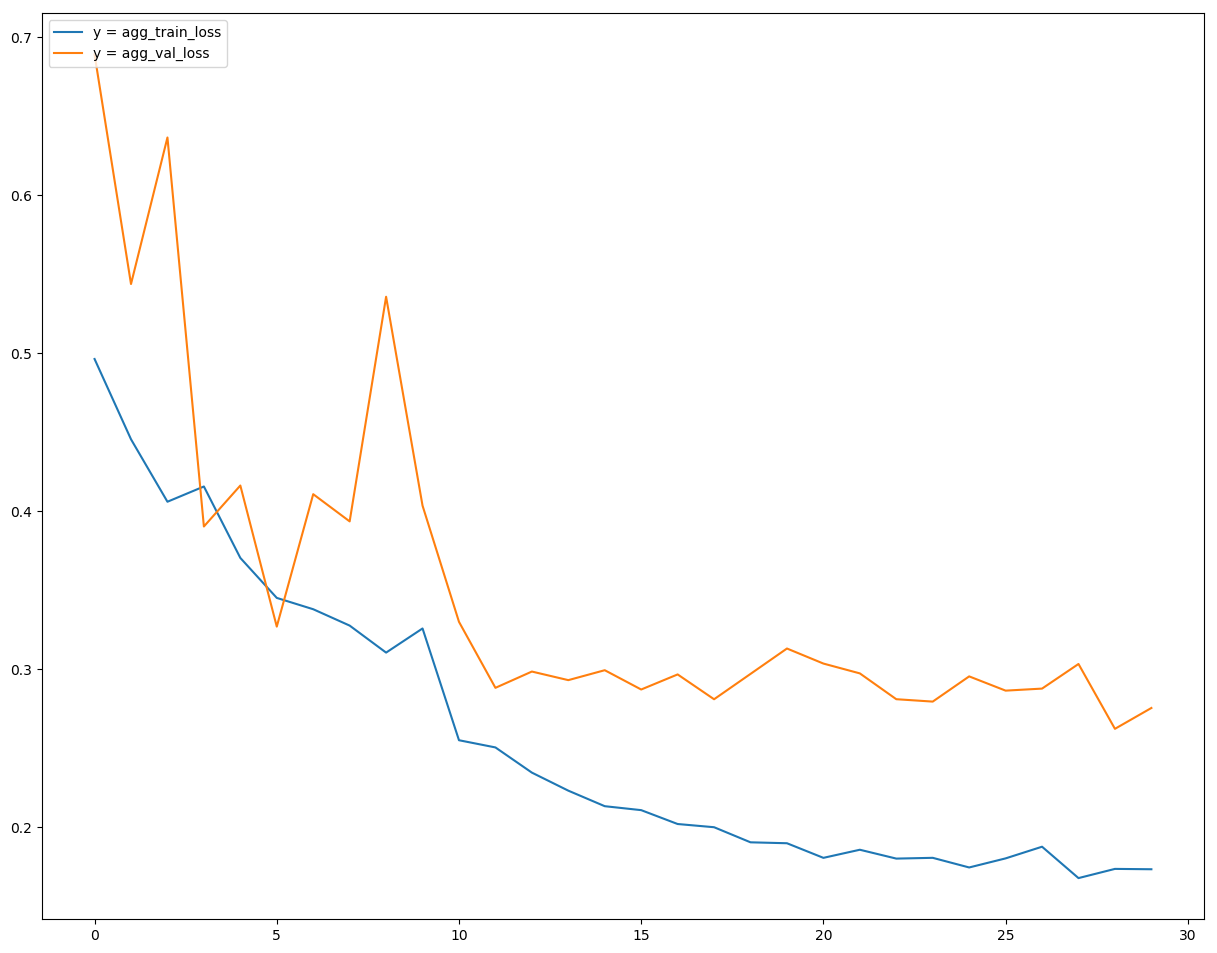

In [0]:
figure(num=None, figsize=(15, 12), dpi=100, facecolor='w', edgecolor='k')
plt.plot(agg_train_loss)
plt.plot(agg_val_loss)
#plt.xticks(np.arange(0, len(batch_loss), batch_size)) 
plt.legend(['y = agg_train_loss', 'y = agg_val_loss'], loc='upper left')
plt.show()

## Calculate Kappa's  coefficients 

In [0]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [0]:
optR = OptimizedRounder()
optR.fit(test_preds, target)
coefficients = optR.coefficients()
valid_predictions = optR.predict(test_preds, coefficients)
print(coefficients)

[0.50782273 1.5270388  2.37500542 3.60069168]


## Accuaracy 

In [0]:
valid_preds = np.array(valid_predictions).astype(int).ravel()
targetint = (np.array(target).astype(int)).ravel()
(valid_preds == targetint).sum()/targetint.shape[0]

0.7702127659574468

Kappa Score

In [0]:
optR._kappa_loss(coefficients,test_preds, target)

-0.906611117315969